In [1]:
# Copyright (c) Microsoft Corporation. All rights reserved. 
# Licensed under the MIT License

import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras import Input
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Flatten, LeakyReLU, Conv2D, MaxPooling2D, ZeroPadding2D, Conv2DTranspose, UpSampling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import initializers
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from keras import initializers
from scipy import stats
import tensorflow as tf
import warnings
from privacygan import privacy_gan as pg
from privacygan.mnist import mnist_gan
from datetime import datetime


warnings.filterwarnings("ignore")

print(tf.__version__)

Using TensorFlow backend.


2.3.0


### Load dataset 

In [2]:
# Load MNIST data and concatenate the train+test set
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_test = (X_test.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])
X_all = np.concatenate((X_train,X_test))


#Generate training test split
frac = 0.1 
n = int(frac*len(X_all))
l = np.array(range(len(X_all)))
l = np.random.choice(l,len(l),replace = False)
X = X_all[l[:n]]
X_comp = X_all[l[n:]]

print('training set size:',X.shape)
print('test set size:',X_comp.shape)

training set size: (7000, 784)
test set size: (63000, 784)


### Test Simple GAN 

In [3]:
(generator, discriminator, dLosses, gLosses) = pg.SimpGAN(X, epochs = 1, batchSize = 256)

Epochs: 1
Batch size: 256
Batches per epoch: 27.34375
epoch = 1/1, d_loss=0.534, g_loss=0.747                                                                                                                    


In [4]:
#perform white box attack
Acc = pg.WBattack(X,X_comp, discriminator)

White-box attack accuracy: 0.09714285714285714


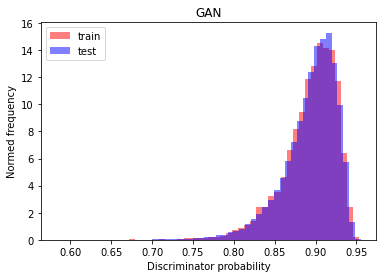

In [5]:
#plot distribution of discriminator scores of training and test set
plt.hist(discriminator.predict(X)[:,0],color = 'r', alpha = 0.5, label = 'train', density = True, bins = 50)
plt.hist(discriminator.predict(X_comp)[:,0],color = 'b', alpha = 0.5, label = 'test', density = True, bins = 50)
plt.xlabel('Discriminator probability')
plt.ylabel('Normed frequency')
plt.title('GAN')
plt.legend()

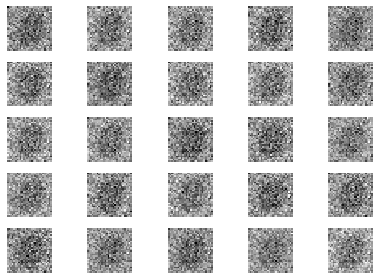

In [6]:
#Generate fake images
pg.DisplayImages(generator, figSize=(5,5), NoImages = 25)

### Test privGAN

In [7]:
### Test privGAN (with n_reps = 2)
K.clear_session()
optim = Adam(lr=0.0002, beta_1=0.5)
generators = [mnist_gan.MNIST_Generator(optim = Adam(lr=0.0002, beta_1=0.5)),
              mnist_gan.MNIST_Generator(optim = Adam(lr=0.0002, beta_1=0.5))]
discriminators = [mnist_gan.MNIST_Discriminator(optim = Adam(lr=0.0002, beta_1=0.5))
                  ,mnist_gan.MNIST_Discriminator(optim = Adam(lr=0.0002, beta_1=0.5))]
pDisc = mnist_gan.MNIST_DiscriminatorPrivate(OutSize = 2, 
                                      optim = Adam(lr=0.0002, beta_1=0.5))

(generators, discriminators, _, dLosses, dpLosses, gLosses)= pg.privGAN(X, epochs = 1, 
                                                                           disc_epochs=1,
                                                                           batchSize=256,
                                                                           generators = generators, 
                                                                           discriminators = discriminators,
                                                                           pDisc = pDisc,
                                                                           optim = optim,
                                                                           privacy_ratio = 1.0)

28/28 [==============================] - 3s 96ms/step - loss: 0.7399 - val_loss: 0.7112
dp-Accuracy: 0.5012857142857143
Epochs: 1
Batch size: 256
Batches per epoch: 13
epoch = 0/1, batch = 12/13                                                                                                     
dLosses = [0.44595609 0.42852396]
dpLosses = 0.0
gLosses = 2.845659824518057
dp-Accuracy: 0.0


In [8]:
#perform white box attack
pg.WBattack_priv(X,X_comp, discriminators)

White-box attack accuracy (max): 0.10214285714285715
White-box attack accuracy (mean): 0.10085714285714285


(0.10214285714285715, 0.10085714285714285)

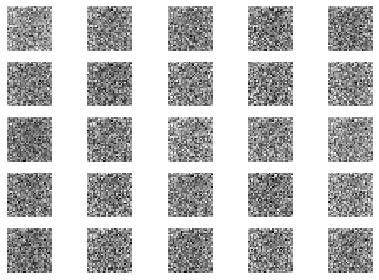

In [9]:
#Generate fake images
pg.DisplayImages(generators[1], figSize=(5,5), NoImages = 25)

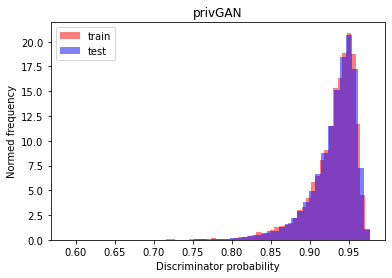

In [10]:
#plot distribution of discriminator scores of training and test set
plt.hist(discriminators[0].predict(X)[:,0],color = 'r', alpha = 0.5, label = 'train', density = True, bins = 50)
plt.hist(discriminators[0].predict(X_comp)[:,0],color = 'b', alpha = 0.5, label = 'test', density = True, bins = 50)
plt.xlabel('Discriminator probability')
plt.ylabel('Normed frequency')
plt.title('privGAN')
plt.legend()